In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import warnings
warnings.filterwarnings('ignore')

# Predictions exploration

In [2]:
X_train = pd.DataFrame(columns=["ET","RF","KNN","XGB","MLP1","MLP2"])
for i in range(4):
    df = pd.read_csv("Datasets/ET_predicted_step1_subset_{}.csv".format(i), index_col=0)
    df["RF"] = pd.read_csv("Datasets/RF_predicted_step1_subset_{}.csv".format(i), index_col=0)
    df["KNN"] = pd.read_csv("Datasets/KNN_predicted_step1_subset_{}.csv".format(i), index_col=0)
    df["XGB"] = pd.read_csv("Datasets/XGB_predicted_step1_subset_{}.csv".format(i), index_col=0).astype(int) + 1
    df["MLP1"] = pd.read_csv("Datasets/MLP1_predicted_step1_subset_{}.csv".format(i), index_col=0).astype(int) + 1
    df["MLP2"] = pd.read_csv("Datasets/MLP2_predicted_step1_subset_{}.csv".format(i), index_col=0).astype(int) + 1
    X_train = pd.concat([X_train,df])
y_train = pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]

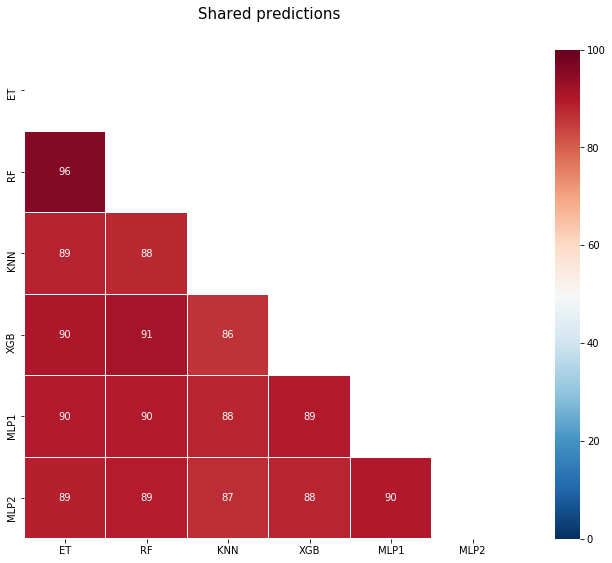

In [3]:
corr = pd.DataFrame(index=X_train.columns, columns=X_train.columns).fillna(0)
for i in range(1, len(corr)):
    for j in range(0, i):
        corr.iloc[i,j]= ((X_train.iloc[:,i] - X_train.iloc[:,j]).value_counts()[0])/len(X_train)*100
colormap = plt.cm.RdBu_r
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(15,9))
plt.title('Shared predictions', y=1.05, size=15)
sns.heatmap(corr ,linewidths=0.1, vmax=100, vmin=0, mask=mask,
            square=True, cmap=colormap, linecolor='white', annot=True)

Random Forest and Extra Trees are highly correlated and do not add enough variance.

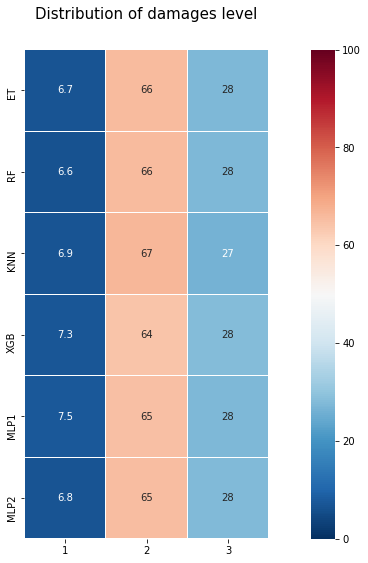

In [4]:
level = pd.DataFrame(index=X_train.columns, columns=range(1,4)).fillna(0)
for i in level.index:
    for j in level.columns:
        level.loc[i,j]= X_train[i].value_counts()[j]/len(X_train)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(15,9))
plt.title('Distribution of damages level', y=1.05, size=15)
sns.heatmap(level ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

([<matplotlib.axis.XTick at 0x1d900619fd0>,
 <a list of 9 Text xticklabel objects>)

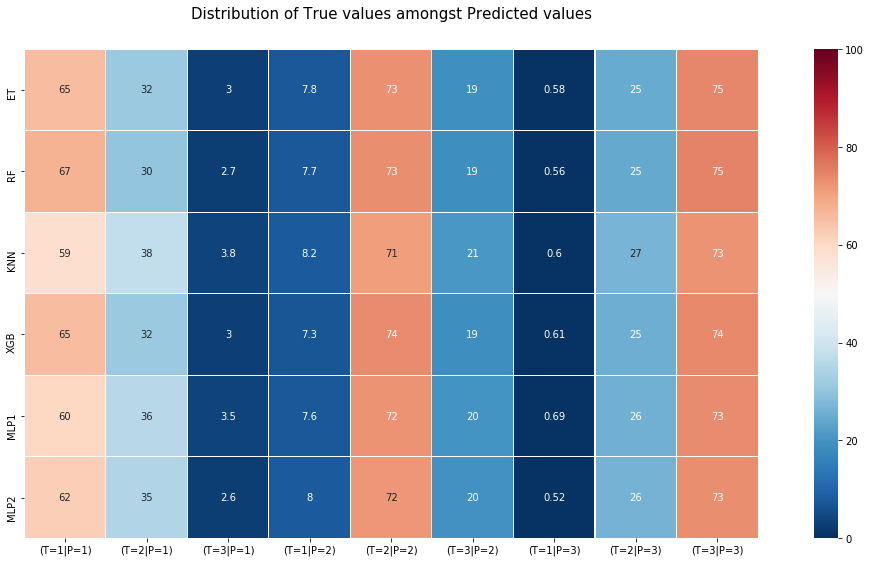

In [5]:
d1 = pd.DataFrame(index=X_train.columns, columns=np.arange(1,10)).fillna(0)
for i in d1.index:
    for j in d1.columns[:4]:
        sample = X_train[X_train[i]==1][i]
        d1.loc[i,:4]= y_train.loc[sample.index].value_counts()/len(sample)*100
    for j in d1.columns[4:7]:
        sample = X_train[X_train[i]==2][i]
        d1.loc[i,4:7]= (y_train.loc[sample.index]+3).value_counts()/len(sample)*100
    for j in d1.columns[:7]:
        sample = X_train[X_train[i]==3][i]
        d1.loc[i,7:]= (y_train.loc[sample.index]+6).value_counts()/len(sample)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(20,9))
plt.title('Distribution of True values amongst Predicted values', y=1.05, size=15)
sns.heatmap(d1.fillna(0) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.xticks(ticks=np.arange(1,10)-0.5, labels=["(T=1|P=1)", "(T=2|P=1)", "(T=3|P=1)","(T=1|P=2)", "(T=2|P=2)", "(T=3|P=2)",
                                             "(T=1|P=3)", "(T=2|P=3)", "(T=3|P=3)"])

All models have a bias regarding 1, with an accuracy of only about 65% in buildings predicted 1.
They are better for 2 and 3, with an accuracy of about 72%.

([<matplotlib.axis.XTick at 0x1d90073a748>,
 <a list of 9 Text xticklabel objects>)

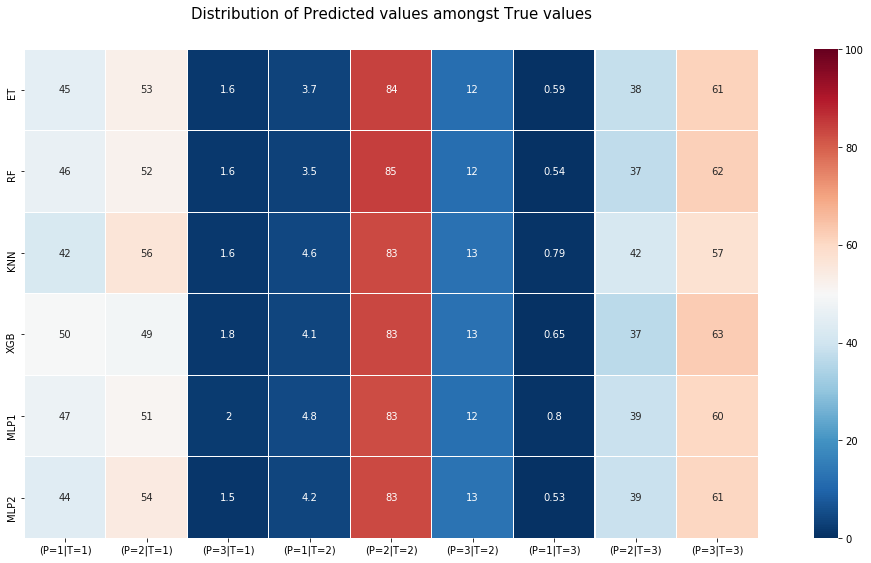

In [6]:
d1 = pd.DataFrame(index=X_train.columns, columns=np.arange(1,10)).fillna(0)
for i in d1.index:
    for j in d1.columns[:4]:
        sample = y_train[y_train==1]
        d1.loc[i,:4]= X_train.loc[sample.index][i].value_counts()/len(sample)*100
    for j in d1.columns[4:7]:
        sample = y_train[y_train==2]
        d1.loc[i,4:7]= (X_train.loc[sample.index][i]+3).value_counts()/len(sample)*100
    for j in d1.columns[:7]:
        sample = y_train[y_train==3]
        d1.loc[i,7:]= (X_train.loc[sample.index][i]+6).value_counts()/len(sample)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(20,9))
plt.title('Distribution of Predicted values amongst True values', y=1.05, size=15)
sns.heatmap(d1.fillna(0) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.xticks(ticks=np.arange(1,10)-0.5, labels=["(P=1|T=1)", "(P=2|T=1)", "(P=3|T=1)","(P=1|T=2)", "(P=2|T=2)", "(P=3|T=2)",
                                              "(P=1|T=3)", "(P=2|T=3)", "(P=3|T=3)"])

All models have a bias regarding 1, with an accuracy of only about 65% in buildings predicted 1. They are better for 2 and 3, with an accuracy of about 72%.

# XGBoost tuning

Now I will tune a model to infer the best predictions with predictions of all previous models.

In [8]:
import xgboost as xgb

In [9]:
spaceXGB  = [Real(0.40, 0.70, name="learning_rate"),
             Integer(3, 7, name="n_estimators"),
             Integer(3, 7, name="max_depth")]

In [10]:
y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"] - 1
X_test = pd.read_csv("Datasets/ET_predicted_step2_subset_4.csv", index_col=0)
X_test["RF"] = pd.read_csv("Datasets/RF_predicted_step2_subset_4.csv", index_col=0)
X_test["KNN"] = pd.read_csv("Datasets/KNN_predicted_step2_subset_4.csv", index_col=0)
X_test["XGB"] = pd.read_csv("Datasets/XGB_predicted_step2_subset_4.csv", index_col=0).astype(int) + 1
X_test["MLP1"] = pd.read_csv("Datasets/MLP1_predicted_step2_subset_4.csv", index_col=0).astype(int) + 1
X_test["MLP2"] = pd.read_csv("Datasets/MLP2_predicted_step2_subset_4.csv", index_col=0).astype(int) + 1
y_test= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_test.index]["damage_grade"]-1

In [11]:
@use_named_args(spaceXGB)
def objectiveXGB(**params):
    xgboost.set_params(**params)
    xgboost.fit(X_train.astype(int),y_train)
    predict = xgboost.predict(X_test)
    e = f1_score(y_test, predict, average='micro')
    print(e, [(a, params[a]) for a in params])
    return 1 - e

In [12]:
xgboost = xgb.XGBRegressor(booster='gbtree', objective ='multi:softmax',  num_class=3)
res_xgb = gp_minimize(objectiveXGB, spaceXGB, n_calls=20, random_state=0)
1-res_xgb.fun, res_xgb.x[0], res_xgb.x[1], res_xgb.x[2]

0.7357878782064811 [('learning_rate', 0.5778533854675055), ('n_estimators', 6), ('max_depth', 6)]
0.7355000863375607 [('learning_rate', 0.6541755216352376), ('n_estimators', 5), ('max_depth', 5)]
0.7364018341935112 [('learning_rate', 0.4892603819633417), ('n_estimators', 3), ('max_depth', 4)]
0.7356343892097237 [('learning_rate', 0.543299535196405), ('n_estimators', 6), ('max_depth', 5)]
0.7357878782064811 [('learning_rate', 0.517835438830249), ('n_estimators', 6), ('max_depth', 4)]
0.7358454365802651 [('learning_rate', 0.5944515616153592), ('n_estimators', 4), ('max_depth', 7)]
0.7354809002129659 [('learning_rate', 0.44210523412379354), ('n_estimators', 6), ('max_depth', 5)]
0.7353849695899926 [('learning_rate', 0.6402732255938933), ('n_estimators', 5), ('max_depth', 6)]
0.7356343892097237 [('learning_rate', 0.616189796417775), ('n_estimators', 5), ('max_depth', 5)]
0.7360564839508068 [('learning_rate', 0.6275846872967072), ('n_estimators', 3), ('max_depth', 5)]
0.7353274112162085 [('

(0.7364018341935112, 0.4892603819633417, 3, 4)

# Submission

Finally, I train the best ensemble learning model with the whole dataset and predict a submission.

In [13]:
X_train = pd.DataFrame(columns=["ET","RF","KNN","XGB", "MLP1", "MLP2"])
for i in range(5):
    df = pd.read_csv("Datasets/ET_predicted_step2_subset_{}.csv".format(i), index_col=0)
    df["RF"] = pd.read_csv("Datasets/RF_predicted_step2_subset_{}.csv".format(i), index_col=0)
    df["KNN"] = pd.read_csv("Datasets/KNN_predicted_step2_subset_{}.csv".format(i), index_col=0)
    df["XGB"] = pd.read_csv("Datasets/XGB_predicted_step2_subset_{}.csv".format(i), index_col=0).astype(int) + 1
    df["MLP1"] = pd.read_csv("Datasets/MLP1_predicted_step2_subset_{}.csv".format(i), index_col=0).astype(int) + 1
    df["MLP2"] = pd.read_csv("Datasets/MLP2_predicted_step2_subset_{}.csv".format(i), index_col=0).astype(int) + 1
    X_train = pd.concat([X_train,df])
y_train = pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]-1

In [14]:
X_submission = pd.read_csv("Datasets/ET_predicted_submission.csv", index_col=0)
X_submission["RF"] = pd.read_csv("Datasets/RF_predicted_submission.csv", index_col=0)
X_submission["KNN"] = pd.read_csv("Datasets/KNN_predicted_submission.csv", index_col=0)
X_submission["XGB"] = pd.read_csv("Datasets/XGB_predicted_submission.csv", index_col=0).astype(int) + 1
X_submission["MLP1"] = pd.read_csv("Datasets/MLP1_predicted_submission.csv", index_col=0).astype(int) + 1
X_submission["MLP2"] = pd.read_csv("Datasets/MLP2_predicted_submission.csv", index_col=0).astype(int) + 1

In [15]:
xgboost = xgb.XGBRegressor(booster='gbtree', objective ='multi:softmax',  num_class=3, n_estimators=res_xgb.x[1],
                           learning_rate=res_xgb.x[0], max_depth=res_xgb.x[2])
xgboost.fit(X_train.astype(int),y_train)
submission = pd.DataFrame(xgboost.predict(X_submission).astype(int), index=X_submission.index, columns=["damage_grade"])+1

In [16]:
submission.to_csv("Submissions/submission10.csv")

F1 score of this submission on DrivenData.org : 0.7342.

In conclusion, if I want to improve my score, I think I may look for a better preprocessing and train more specific algorithms (especially, I need models very good to predict (damage=1 or else) and (damage=3 or else).